In [1]:
from __future__ import print_function
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.onnx

import torchvision
from torchvision import transforms, datasets, models

import onnx

import helper

from collections import OrderedDict

import numpy as np
import timeit
import glob
import matplotlib.pyplot as plt
from PIL import Image

## Switching from ND Array > Pytorch Tensor > ND Array

In [2]:
randomArray = np.random.randn(5, 3)
randomArray

array([[ 0.83990587,  0.0784526 ,  0.80025195],
       [ 0.19367976,  0.30009642, -0.29645746],
       [ 0.42038496,  0.45896885, -0.40062166],
       [-1.87579788, -0.17460797,  0.30850328],
       [ 0.29063996, -0.50875835, -0.4642765 ]])

In [3]:
randomTensor = torch.from_numpy(randomArray)
randomTensor

tensor([[ 0.8399,  0.0785,  0.8003],
        [ 0.1937,  0.3001, -0.2965],
        [ 0.4204,  0.4590, -0.4006],
        [-1.8758, -0.1746,  0.3085],
        [ 0.2906, -0.5088, -0.4643]], dtype=torch.float64)

In [4]:
randomTensor.numpy()

array([[ 0.83990587,  0.0784526 ,  0.80025195],
       [ 0.19367976,  0.30009642, -0.29645746],
       [ 0.42038496,  0.45896885, -0.40062166],
       [-1.87579788, -0.17460797,  0.30850328],
       [ 0.29063996, -0.50875835, -0.4642765 ]])

# Switching from using CPU - GPU


In [5]:
cpu = torch.device('cpu')
cuda = torch.device('cuda')

In [6]:
cuda_0 = torch.device('cuda:0')
cuda_2 = torch.device('cuda:2')

In [7]:
w1 = torch.rand(10000, 10000, device='cpu')
x1 = torch.rand(10000, 10000, device='cpu')

In [8]:
start_cpu = timeit.default_timer()

x1.matmul(w1)

end_cpu = timeit.default_timer()
print('Timelapse: ', end_cpu- start_cpu)

Timelapse:  12.776667870999972


In [9]:
start_gpu = timeit.default_timer()

x1 = x1.cuda()
w1 = w1.cuda()

x1.matmul(w1)

end_gpu = timeit.default_timer()
print('Timelapse: ', end_gpu - start_gpu)

Timelapse:  2.396250158999919


In [10]:
print('Difference: ', np.round((end_cpu- start_cpu)/(end_gpu - start_gpu), 0),'x faster')

Difference:  5.0 x faster


# Calculate the gradient

In [11]:
# By default, requires_grad is set to False
x = torch.randn(5, 5)
y = torch.randn(5, 5)
z = torch.randn((5, 5), requires_grad=True)

result = x + y
print(result.requires_grad)

second_result = result + z
print(second_result.requires_grad)

False
True


In [12]:
input = Variable(torch.ones(2, 2).cuda(), requires_grad=True)
print("Before: ", input.grad)

output = input.mean()
output.backward()

print("After: ", input.grad)

Before:  None
After:  tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]], device='cuda:0')


#  Object Oriented Programming Style

In [13]:
input_size = 784
hidden_size = [128, 64]
output_size = 10

In [14]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Network, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

In [15]:
oop_model = Network(input_size=input_size, 
                    hidden_size=hidden_size, 
                    output_size=output_size)
oop_model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

By default, weights and bias are automatically filled up

In [16]:
print(oop_model.fc1.weight)
print(oop_model.fc1.bias)

Parameter containing:
tensor([[ 0.0040, -0.0093,  0.0208,  ...,  0.0099, -0.0052,  0.0343],
        [-0.0096,  0.0019, -0.0305,  ...,  0.0243,  0.0081,  0.0208],
        [ 0.0245, -0.0117, -0.0283,  ...,  0.0338, -0.0306, -0.0145],
        ...,
        [ 0.0053,  0.0017,  0.0033,  ..., -0.0226, -0.0281,  0.0337],
        [ 0.0142,  0.0104, -0.0008,  ..., -0.0060,  0.0323, -0.0104],
        [ 0.0181, -0.0232, -0.0085,  ...,  0.0254, -0.0268,  0.0343]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0277,  0.0265, -0.0271,  0.0316, -0.0351, -0.0038,  0.0353, -0.0215,
        -0.0049,  0.0247,  0.0074, -0.0245,  0.0317, -0.0053, -0.0273,  0.0130,
         0.0038,  0.0302,  0.0284,  0.0279, -0.0329,  0.0289,  0.0276,  0.0243,
        -0.0199,  0.0041, -0.0313, -0.0097,  0.0209,  0.0345, -0.0120, -0.0225,
         0.0225, -0.0248,  0.0037,  0.0174, -0.0135,  0.0346,  0.0073,  0.0294,
         0.0192, -0.0102, -0.0234, -0.0292, -0.0031,  0.0315,  0.0036,  0.0237,
        -0.0026

We can also modify the value of these tensors

In [17]:
# Set bias to be zero
oop_model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [18]:
# Set weight into normal distribution with standard deviation of .01
oop_model.fc1.weight.data.normal_(std=.01)

tensor([[ 0.0011, -0.0179, -0.0172,  ..., -0.0067,  0.0092, -0.0067],
        [-0.0165, -0.0179,  0.0016,  ...,  0.0160,  0.0087,  0.0094],
        [ 0.0111, -0.0054, -0.0124,  ..., -0.0066,  0.0083, -0.0167],
        ...,
        [-0.0027,  0.0144,  0.0137,  ..., -0.0097, -0.0067,  0.0004],
        [ 0.0030, -0.0020,  0.0070,  ..., -0.0116,  0.0001,  0.0112],
        [-0.0063, -0.0037, -0.0151,  ..., -0.0079,  0.0062,  0.0119]])

# Sequential Style

In [ ]:
sequential_model = nn.Sequential(nn.Linear(in_features=input_size, out_features=hidden_size[0]),
                                 nn.ReLU(),
                                 nn.Linear(in_features=hidden_size[0], out_features=hidden_size[1]),
                                 nn.ReLU(),
                                 nn.Linear(in_features=hidden_size[1], out_features=output_size),
                                 nn.Softmax(dim=1))

sequential_model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)

# Sequential Style - Alternative

In [ ]:
alt_sequential_model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(input_size, hidden_size[0])),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(hidden_size[0], hidden_size[1])),
    ('relu2', nn.ReLU()),
    ('output', nn.Linear(hidden_size[1], output_size)),
    ('softmax', nn.Softmax(dim=1))
]))

alt_sequential_model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

We can pick up any layer easily like you used to code in Python

In [ ]:
print(sequential_model[0])
print(sequential_model[1])

print(oop_model.fc1)
print(oop_model.fc2)

print(alt_sequential_model.fc2)
print(alt_sequential_model.relu1)

Linear(in_features=784, out_features=128, bias=True)
ReLU()
Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=128, out_features=64, bias=True)
ReLU()


# Simple Neural Network - Fashion MNIST

## Define Pre-processing Pipeline

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

## Prepare Datasets

In [ ]:
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Initialize Input Parameters

In [ ]:
input_size = 784
output_size = 10
hidden_layers = [512, 256, 128]

## Setup

In [ ]:
model = helper.Network(input_size, output_size, hidden_layers)
criterion = nn.NLLLoss() # negative log likelihood loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Train Model

In [ ]:
model.to(device)
helper.train_model(model, trainloader, testloader, criterion, optimizer, device=device, isTransfer=False, epochs=1)

Device: cuda..  Epoch: 1/1..  Training Loss: 2.218..  Test Loss: 1.912..  Test Accuracy: 0.360
Device: cuda..  Epoch: 1/1..  Training Loss: 3.764..  Test Loss: 1.181..  Test Accuracy: 0.501
Device: cuda..  Epoch: 1/1..  Training Loss: 4.800..  Test Loss: 0.932..  Test Accuracy: 0.641
Device: cuda..  Epoch: 1/1..  Training Loss: 5.678..  Test Loss: 0.863..  Test Accuracy: 0.664
Device: cuda..  Epoch: 1/1..  Training Loss: 6.540..  Test Loss: 0.854..  Test Accuracy: 0.677
Device: cuda..  Epoch: 1/1..  Training Loss: 7.355..  Test Loss: 0.774..  Test Accuracy: 0.714
Device: cuda..  Epoch: 1/1..  Training Loss: 8.032..  Test Loss: 0.693..  Test Accuracy: 0.740
Device: cuda..  Epoch: 1/1..  Training Loss: 8.686..  Test Loss: 0.664..  Test Accuracy: 0.737
Device: cuda..  Epoch: 1/1..  Training Loss: 9.329..  Test Loss: 0.640..  Test Accuracy: 0.758
Device: cuda..  Epoch: 1/1..  Training Loss: 9.942..  Test Loss: 0.700..  Test Accuracy: 0.709
Device: cuda..  Epoch: 1/1..  Training Loss: 10.55

Device: cuda..  Epoch: 1/1..  Training Loss: 45.951..  Test Loss: 0.416..  Test Accuracy: 0.852
Device: cuda..  Epoch: 1/1..  Training Loss: 46.335..  Test Loss: 0.424..  Test Accuracy: 0.846
Device: cuda..  Epoch: 1/1..  Training Loss: 46.695..  Test Loss: 0.418..  Test Accuracy: 0.849
Device: cuda..  Epoch: 1/1..  Training Loss: 47.089..  Test Loss: 0.419..  Test Accuracy: 0.850
Device: cuda..  Epoch: 1/1..  Training Loss: 47.530..  Test Loss: 0.424..  Test Accuracy: 0.844
Device: cuda..  Epoch: 1/1..  Training Loss: 47.926..  Test Loss: 0.438..  Test Accuracy: 0.839
Device: cuda..  Epoch: 1/1..  Training Loss: 48.331..  Test Loss: 0.429..  Test Accuracy: 0.846


# Save Model

In [ ]:
checkpoint = {'input_size': input_size,
              'output_size': output_size,
              'hidden_layers': hidden_layers,
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'mymodel.pth')

# Load Model

In [ ]:
checkpoint = torch.load('mymodel.pth')
model = helper.Network(checkpoint['input_size'],
                       checkpoint['output_size'],
                       checkpoint['hidden_layers'])

model.load_state_dict(checkpoint['state_dict'])

print(model)

Network(
  (fc): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)


# Finetuning by Using Pre-trained Model

In [ ]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 500)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(500, 2)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [ ]:
data_dir = 'Cat_Dog_data/'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


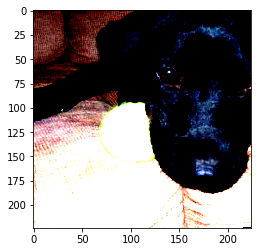

In [ ]:
image, label = next(iter(trainloader))
plt.imshow(image[0].numpy().transpose((1, 2, 0)))
print(image[0].shape)

In [ ]:
model.to(device)
helper.train_model(model, trainloader, testloader, criterion, optimizer, device=device, epochs=1, isTransfer=True)

Device: cuda..  Epoch: 1/1..  Training Loss: 0.588..  Test Loss: 0.097..  Test Accuracy: 0.975
Device: cuda..  Epoch: 1/1..  Training Loss: 0.766..  Test Loss: 0.061..  Test Accuracy: 0.979
Device: cuda..  Epoch: 1/1..  Training Loss: 0.907..  Test Loss: 0.064..  Test Accuracy: 0.978
Device: cuda..  Epoch: 1/1..  Training Loss: 1.082..  Test Loss: 0.096..  Test Accuracy: 0.966
Device: cuda..  Epoch: 1/1..  Training Loss: 1.254..  Test Loss: 0.044..  Test Accuracy: 0.986
Device: cuda..  Epoch: 1/1..  Training Loss: 1.443..  Test Loss: 0.064..  Test Accuracy: 0.978
Device: cuda..  Epoch: 1/1..  Training Loss: 1.568..  Test Loss: 0.050..  Test Accuracy: 0.982
Device: cuda..  Epoch: 1/1..  Training Loss: 1.689..  Test Loss: 0.051..  Test Accuracy: 0.982
Device: cuda..  Epoch: 1/1..  Training Loss: 1.822..  Test Loss: 0.055..  Test Accuracy: 0.981
Device: cuda..  Epoch: 1/1..  Training Loss: 1.956..  Test Loss: 0.045..  Test Accuracy: 0.983
Device: cuda..  Epoch: 1/1..  Training Loss: 2.100

# Convert from Pytorch to another framework by using ONNX

In [ ]:
checkpoint = torch.load('mymodel.pth')
model = helper.Network(checkpoint['input_size'],
                       checkpoint['output_size'],
                       checkpoint['hidden_layers'])

model.load_state_dict(checkpoint['state_dict'])

# Export
dummy_input = Variable(torch.randn(1, 784, requires_grad=True))
torch.onnx.export(model, dummy_input, 'first_export.onnx')

#Import 
onnx_model = onnx.load('first_export.onnx')

# Vaidate imported model
onnx.checker.check_model(model)
onnx.helper.printable_graph(model.graph)